In [1]:
import pickle
import torch
import numpy as np

In [2]:
exp = '12DriveEndFault'
with open('cwru_data.pkl', 'rb') as file:
    # Deserialize the dictionary
    loaded_dict = pickle.load(file)

data, labels = loaded_dict[exp]
normal_data, normal_labels = loaded_dict['Normal']

data = np.concatenate([data, normal_data], axis=0)
labels = np.concatenate([labels, normal_labels], axis=0)

data = data[:,:, np.newaxis]

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [4]:
with open('augmented_data.pkl', 'rb') as file:
    # Deserialize the dictionary
    loaded_data = pickle.load(file)

X_augmented, y_augmented = loaded_data
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Evaluation

## KL Divergence

In [5]:
import torch.nn.functional as F
def kl_divergence(real_data, generated_data, num_bins = 64):

    """
    Calcule la divergence KL entre les données réelles et générées en utilisant torch.nn.functional.kl_div.
    """
    real_data = real_data.flatten()
    generated_data = generated_data.flatten()

    real_hist, bin_edges = torch.histogram(real_data, bins=num_bins, density=True)
    generated_hist, _ = torch.histogram(generated_data, bins=bin_edges, density=True)

    epsilon = 1e-10
    real_hist = real_hist + epsilon
    generated_hist = generated_hist + epsilon

    real_hist /= real_hist.sum()
    generated_hist /= generated_hist.sum()

    real_log_hist = torch.log(real_hist)

    kl_div = F.kl_div(real_log_hist, generated_hist, reduction="batchmean")
    return kl_div.item()


In [6]:
for label in np.unique(y_train):
    X_train_label = torch.tensor(X_train[y_train == label])
    X_augmented_label = torch.tensor(X_augmented[y_augmented == label])
    print(f"Label {label} -------- {kl_divergence(X_train_label, X_augmented_label)*100:.3f}%")


Label 0 -------- 1.606%
Label 1 -------- 1.002%
Label 2 -------- 0.218%
Label 3 -------- 0.133%
Label 4 -------- 0.501%
Label 5 -------- 0.555%
Label 6 -------- 0.894%
Label 7 -------- 0.163%
Label 8 -------- 0.819%
Label 9 -------- 1.935%
Label 10 -------- 0.755%
Label 11 -------- 1.013%


## Visualization

### PCA

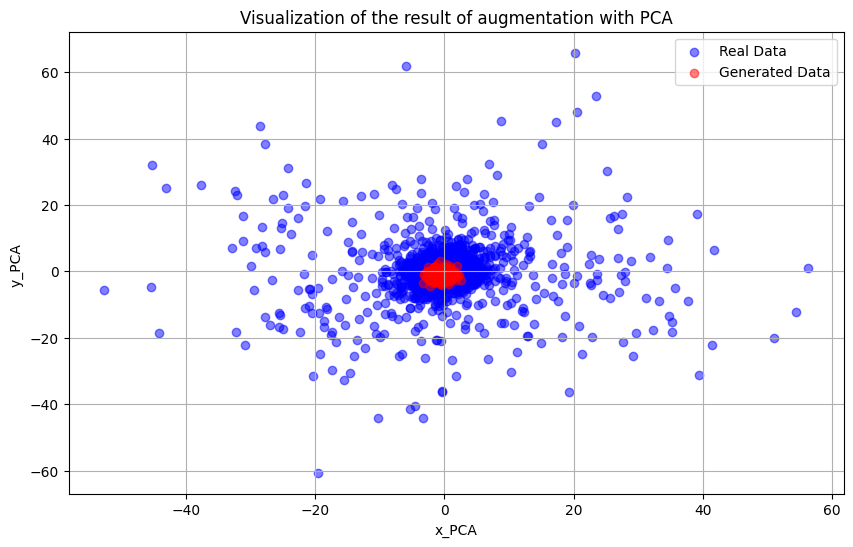

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

real_data = np.squeeze(X_train)
augmented_data = np.squeeze(X_augmented)

real_data = (real_data - np.mean(real_data))/np.std(real_data)
augmented_data = (augmented_data - np.mean(real_data))/np.std(real_data)

pca = PCA(n_components=2)
real_data_pca = pca.fit_transform(real_data)
augmented_data_pca = pca.transform(augmented_data)

# Création des graphiques
plt.figure(figsize=(10, 6))

# Plot PCA
plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], color='blue', label='Real Data', alpha=0.5)
plt.scatter(augmented_data_pca[:, 0], augmented_data_pca[:, 1], color='red', label='Generated Data', alpha=0.5)
plt.title('Visualization of the result of augmentation with PCA')
plt.xlabel('x_PCA')
plt.ylabel('y_PCA ')
plt.grid()
plt.legend()


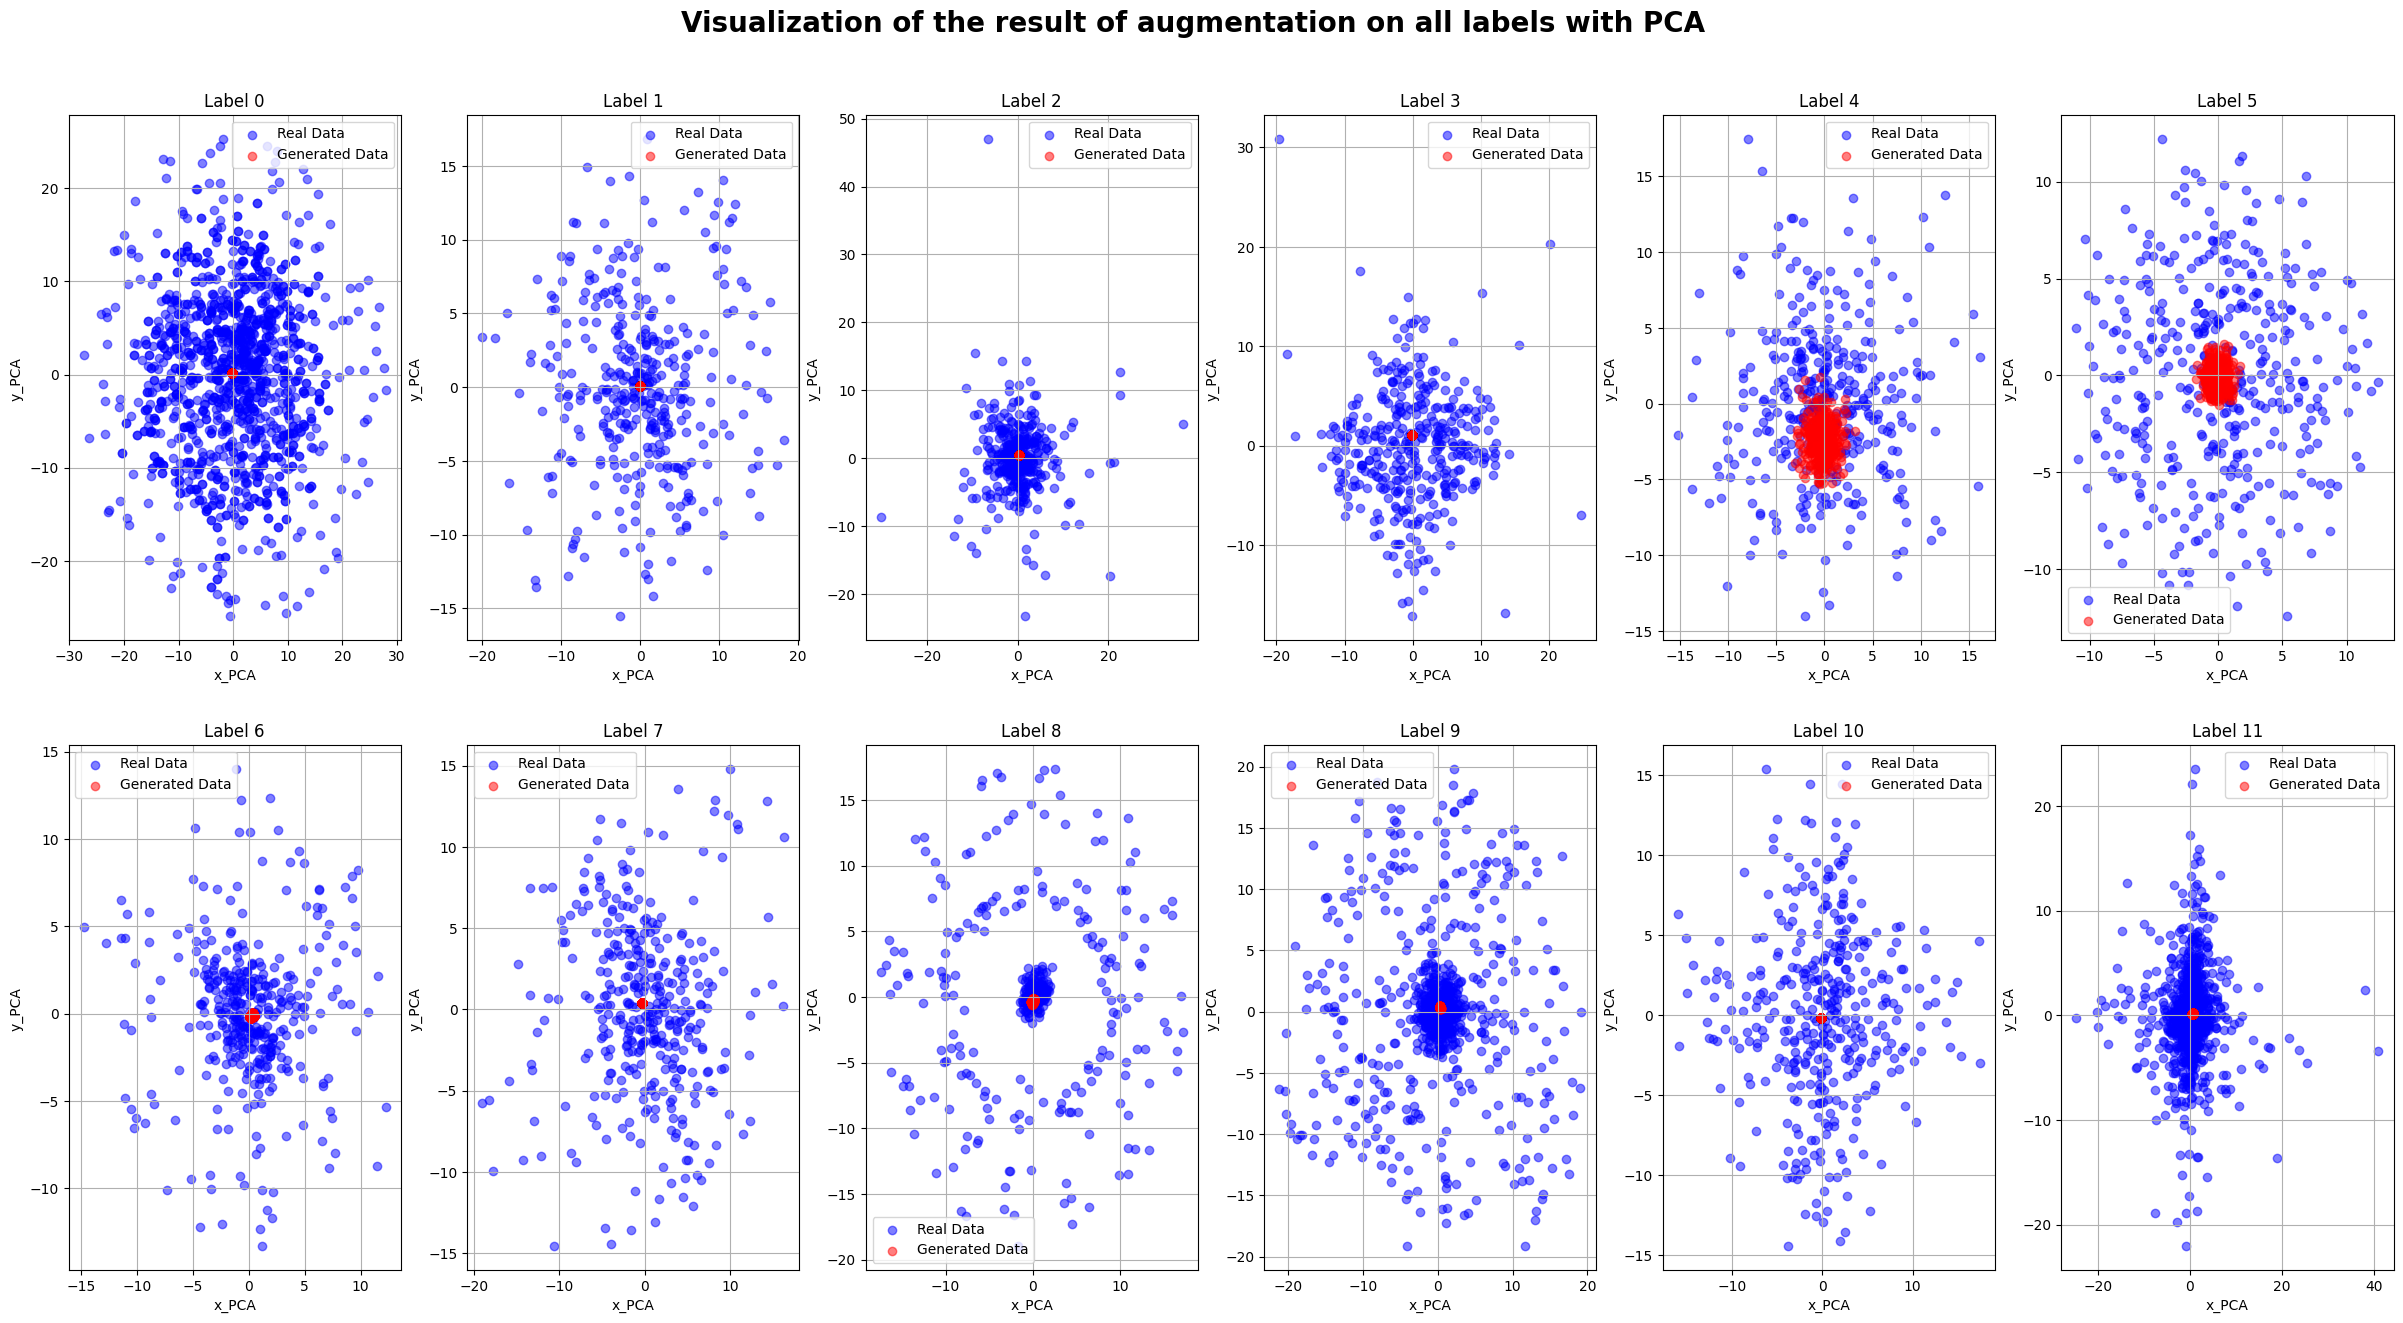

In [8]:
# Création des graphiques
plt.figure(figsize=(30, 15))
plt.suptitle('Visualization of the result of augmentation on all labels with PCA',
             fontsize=20, fontweight='bold', y=0.95)

for label in np.unique(y_train):
  real_data = np.squeeze(X_train[y_train == label])
  augmented_data = np.squeeze(X_augmented[y_augmented == label])

  real_data = (real_data - np.mean(real_data))/np.std(real_data)
  augmented_data = (augmented_data - np.mean(real_data))/np.std(real_data)

  pca = PCA(n_components=2)
  real_data_pca = pca.fit_transform(real_data)
  augmented_data_pca = pca.transform(augmented_data)

  # Plot PCA
  plt.subplot(2, len(np.unique(y_train))//2, label+1)
  plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], color='blue', label='Real Data', alpha=0.5)
  plt.scatter(augmented_data_pca[:, 0], augmented_data_pca[:, 1], color='red', label='Generated Data', alpha=0.5)
  plt.title(f'Label {label}')
  plt.xlabel('x_PCA')
  plt.ylabel('y_PCA ')
  plt.grid()
  plt.legend()

### t-SNE

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


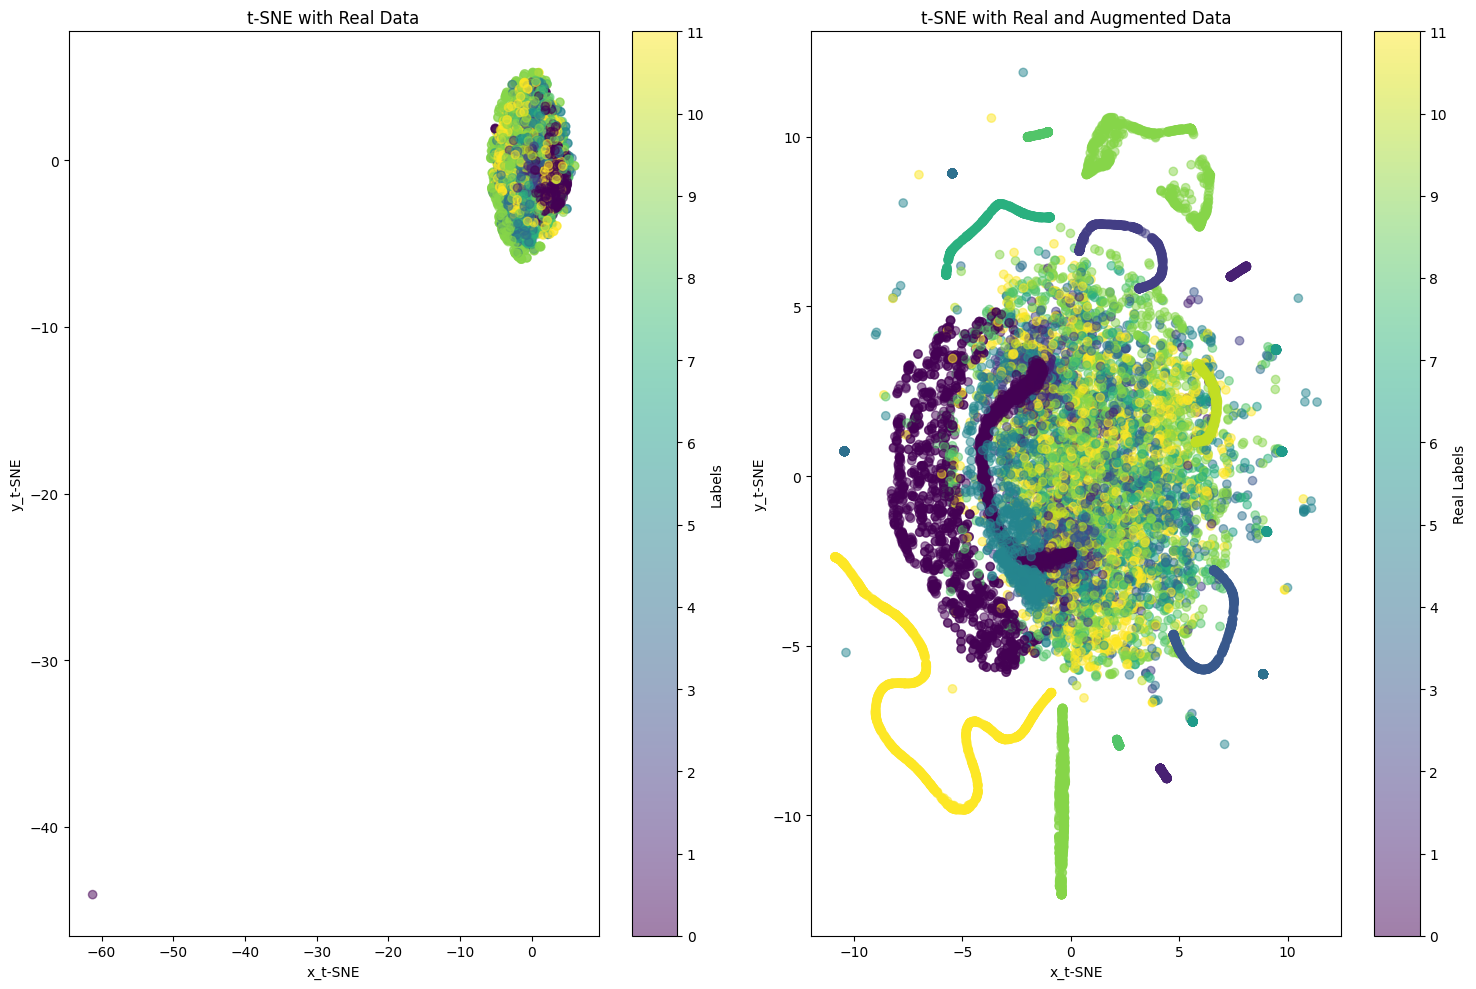

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Normalisation des données
real_data = np.squeeze(X_train)
augmented_data = np.squeeze(X_augmented)

real_data = (real_data - np.mean(real_data)) / np.std(real_data)
augmented_data = (augmented_data - np.mean(real_data)) / np.std(real_data)

# Application de t-SNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)

real_tsne = tsne.fit_transform(real_data)
all_data = np.concatenate((real_data, augmented_data), axis=0)
all_tsne = tsne.fit_transform(all_data)

# Conversion des labels en indices (au cas où)
unique_labels_real = np.unique(y_train)
label_to_index_real = {label: idx for idx, label in enumerate(unique_labels_real)}
y_train_indices = np.array([label_to_index_real[label] for label in y_train])

unique_labels_augmented = np.unique(y_augmented)
label_to_index_augmented = {label: idx for idx, label in enumerate(unique_labels_augmented)}
y_augmented_indices = np.array([label_to_index_augmented[label] for label in y_augmented])

# Création des scatter plots
plt.figure(figsize=(15, 10))

# t-SNE avec données réelles
plt.subplot(1, 2, 1)
scatter_real = plt.scatter(
    real_tsne[:, 0], real_tsne[:, 1],
    c=y_train_indices, cmap='viridis', alpha=0.5, label='Real Data'
)
plt.colorbar(scatter_real, ticks=range(len(unique_labels_real)), label='Labels')
plt.title('t-SNE with Real Data')
plt.xlabel('x_t-SNE')
plt.ylabel('y_t-SNE')

# t-SNE avec données réelles et augmentées
plt.subplot(1, 2, 2)
scatter_all_real = plt.scatter(
    all_tsne[:real_data.shape[0], 0], all_tsne[:real_data.shape[0], 1],
    c=y_train_indices, cmap='viridis', alpha=0.5, label='Real Data'
)
scatter_all_augmented = plt.scatter(
    all_tsne[real_data.shape[0]:, 0], all_tsne[real_data.shape[0]:, 1],
    c=y_augmented_indices, cmap='viridis', alpha=0.5, label='Augmented Data'
)
plt.colorbar(scatter_all_real, ticks=range(len(unique_labels_real)), label='Real Labels')
plt.title('t-SNE with Real and Augmented Data')
plt.xlabel('x_t-SNE')
plt.ylabel('y_t-SNE')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


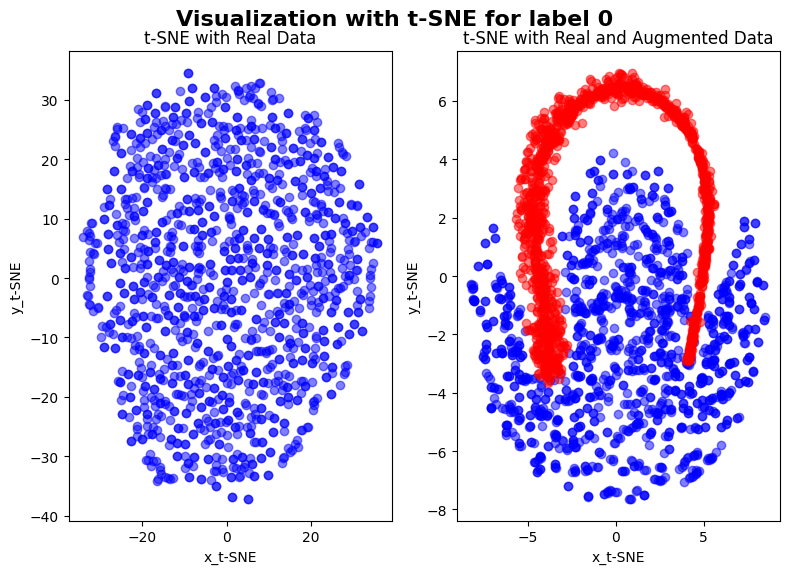

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


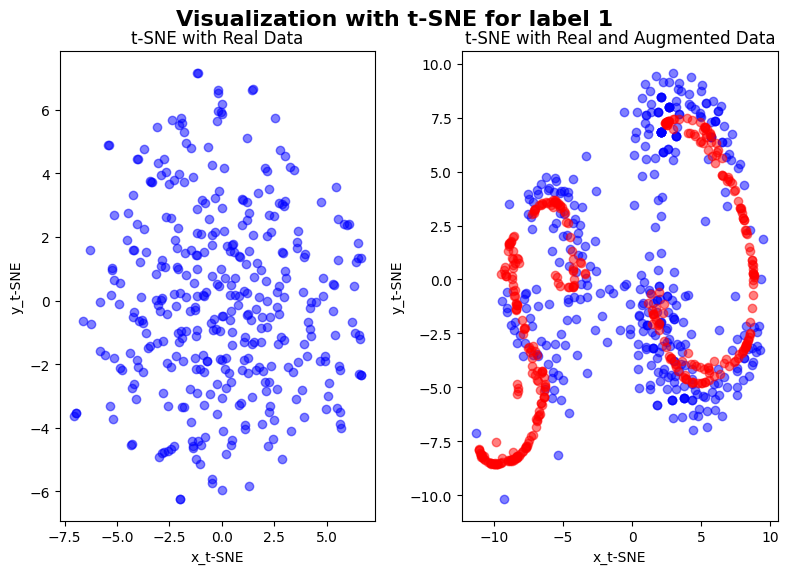

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


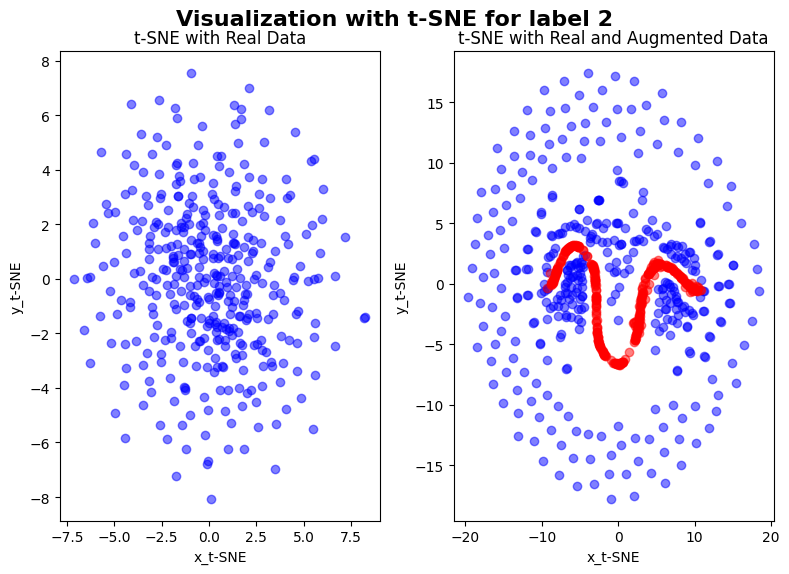

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


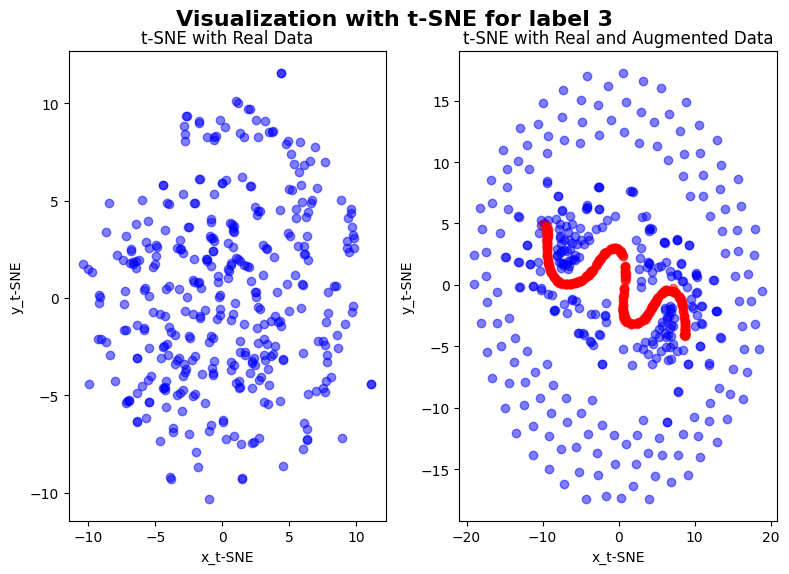

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


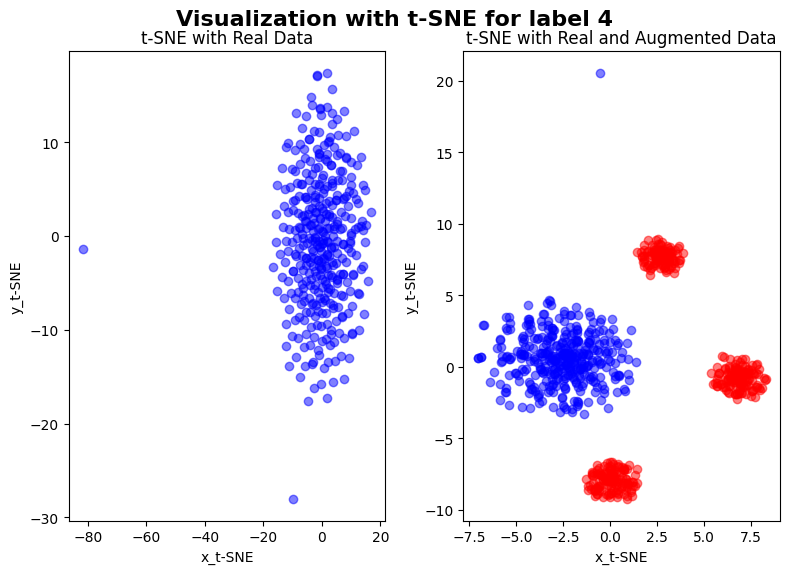

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


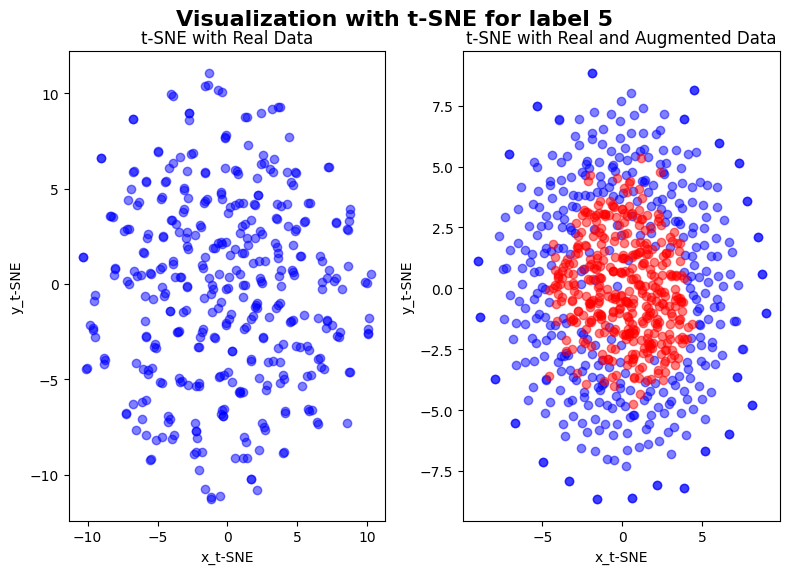

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


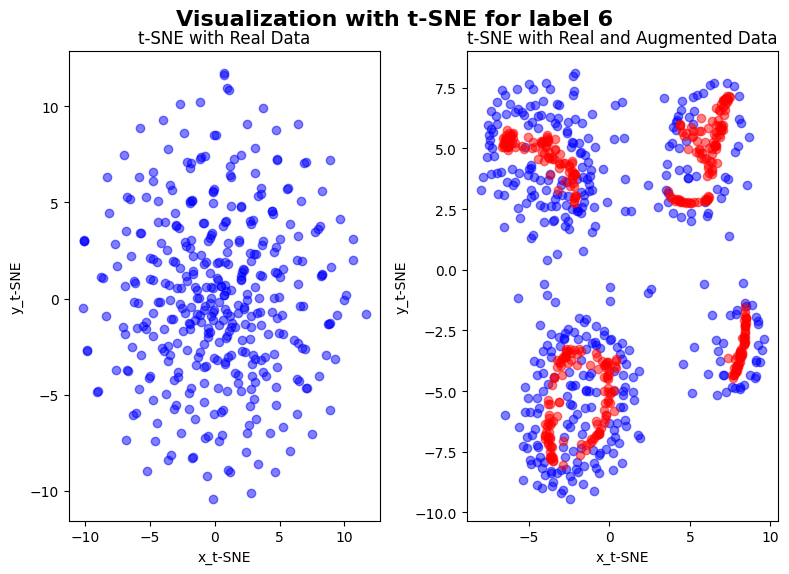

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


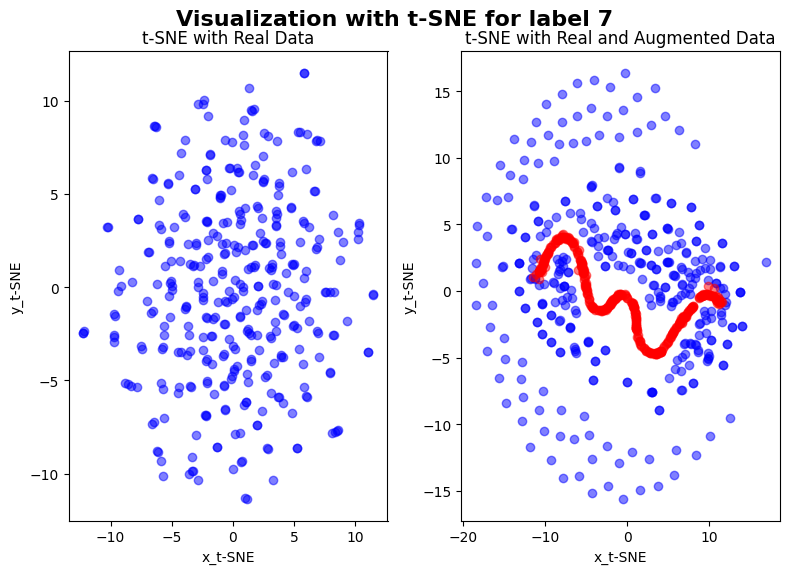

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


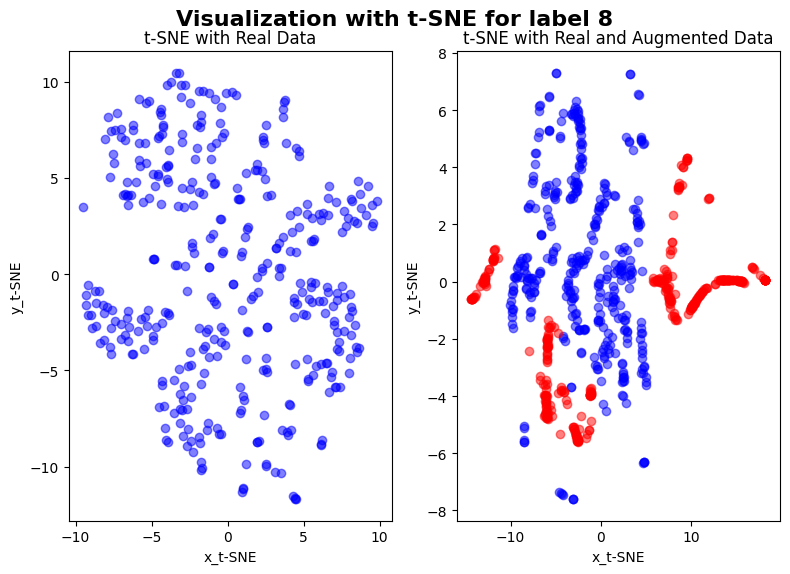

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


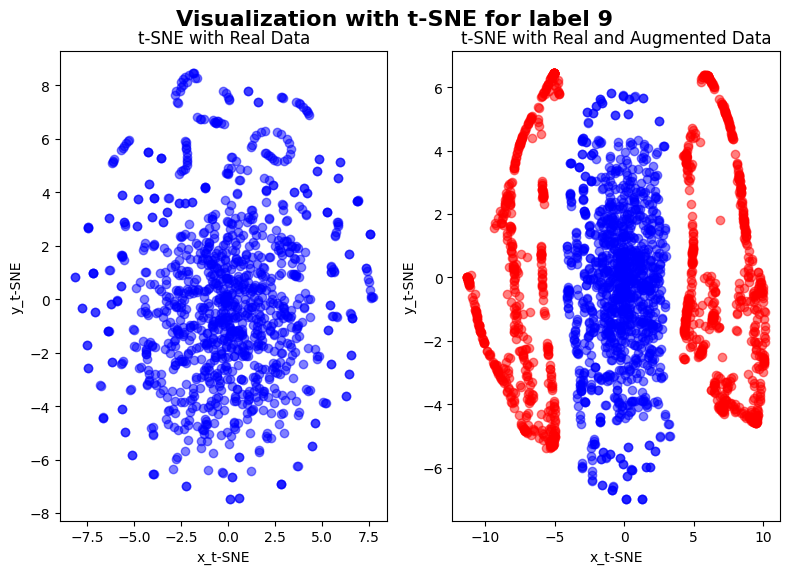

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


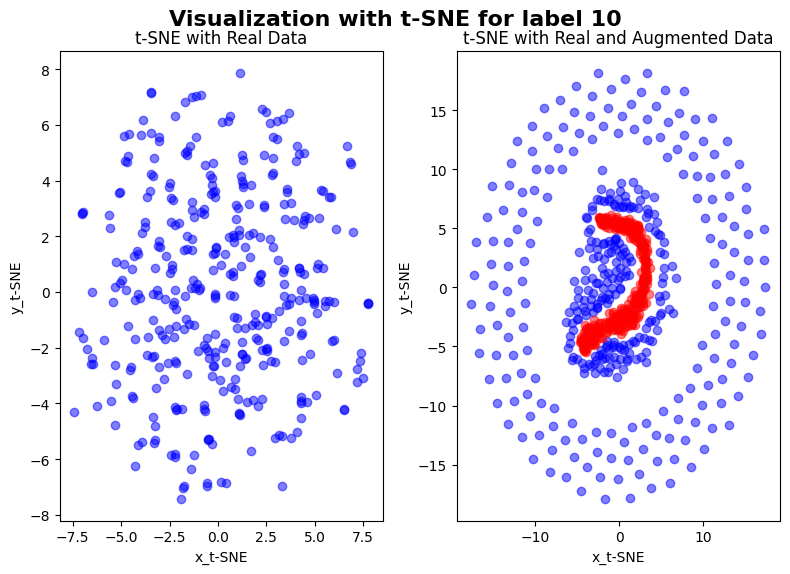

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


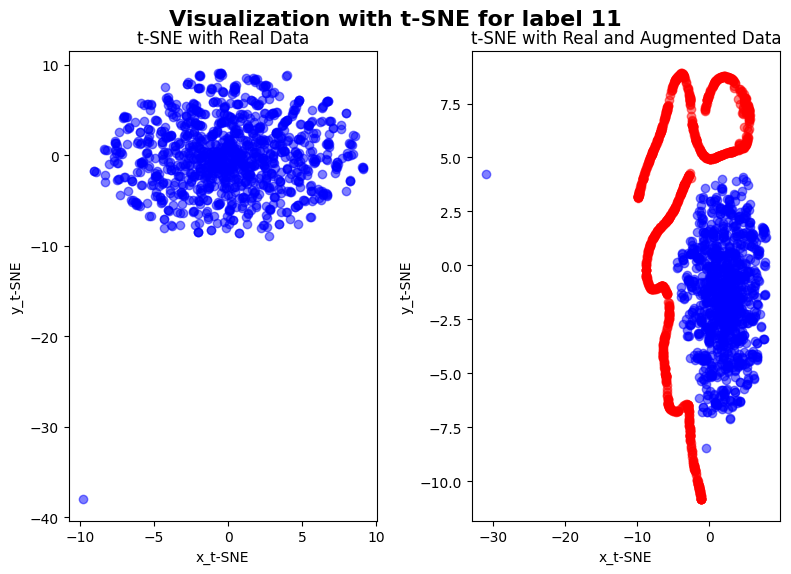

In [10]:
for label in  np.unique(y_train):
  # Normalisation des données
  real_data = np.squeeze(X_train[y_train==label])
  augmented_data = np.squeeze(X_augmented[y_augmented==label])

  real_data = (real_data - np.mean(real_data)) / np.std(real_data)
  augmented_data = (augmented_data - np.mean(real_data)) / np.std(real_data)

  # Application de t-SNE
  tsne = TSNE(n_components=2, perplexity=40, n_iter=300)

  real_tsne = tsne.fit_transform(real_data)
  all_data = np.concatenate((real_data, augmented_data), axis=0)
  all_tsne = tsne.fit_transform(all_data)

  plt.figure(figsize=(8, 6))
  plt.suptitle(f'Visualization with t-SNE for label {label}',
             fontsize=16, fontweight='bold', y=0.95)
  # t-SNE avec données réelles
  plt.subplot(1, 2, 1)
  scatter_real = plt.scatter(
      real_tsne[:, 0], real_tsne[:, 1],
      color='blue',  alpha=0.5, label='Real Data'
  )
  plt.title('t-SNE with Real Data')
  plt.xlabel('x_t-SNE')
  plt.ylabel('y_t-SNE')

  # t-SNE avec données réelles et augmentées
  plt.subplot(1, 2, 2)
  scatter_all_real = plt.scatter(
      all_tsne[:real_data.shape[0], 0], all_tsne[:real_data.shape[0], 1],
      color='blue', alpha=0.5, label='Real Data'
  )
  scatter_all_augmented = plt.scatter(
      all_tsne[real_data.shape[0]:, 0], all_tsne[real_data.shape[0]:, 1],
      color='red', alpha=0.5, label='Augmented Data'
  )
  plt.title('t-SNE with Real and Augmented Data')
  plt.xlabel('x_t-SNE')
  plt.ylabel('y_t-SNE')
  plt.tight_layout()
  plt.show()


## Prediction

In [11]:
n_classes = len(np.unique(y_train))

X_train_combined = np.concatenate([X_train, X_augmented], axis=0)
y_train_combined = np.concatenate([y_train, y_augmented], axis=0)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)

train_augmented_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train_combined, dtype=torch.float32),
    torch.tensor(y_train_combined, dtype=torch.long)
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)


In [12]:
from evaluation import model_evaluation

input_size = X_train.shape[1]  # Dimensions des caractéristiques (features)
# Évaluer sur les données d'entraînement d'origine
print("\n### Évaluation sur le jeu d'entraînement d'origine ###")
results_original = model_evaluation(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    input_size=input_size,
    num_classes=n_classes,
    num_epochs=100,
    device='cuda'
)


### Évaluation sur le jeu d'entraînement d'origine ###

Evaluating MLP model:
Epoch 1/100 - Train Loss: 2.3022 - Train Accuracy: 0.3225
Test Loss: 2.2400 - Test Accuracy: 0.3694
Epoch 2/100 - Train Loss: 2.2118 - Train Accuracy: 0.4004
Test Loss: 2.2075 - Test Accuracy: 0.4071
Epoch 3/100 - Train Loss: 2.1604 - Train Accuracy: 0.4553
Test Loss: 2.1797 - Test Accuracy: 0.4299
Epoch 4/100 - Train Loss: 2.1292 - Train Accuracy: 0.4892
Test Loss: 2.1336 - Test Accuracy: 0.4869
Epoch 5/100 - Train Loss: 2.0958 - Train Accuracy: 0.5197
Test Loss: 2.1297 - Test Accuracy: 0.4840
Epoch 6/100 - Train Loss: 2.0865 - Train Accuracy: 0.5306
Test Loss: 2.1288 - Test Accuracy: 0.4875
Epoch 7/100 - Train Loss: 2.0789 - Train Accuracy: 0.5353
Test Loss: 2.1405 - Test Accuracy: 0.4761
Epoch 8/100 - Train Loss: 2.0701 - Train Accuracy: 0.5468
Test Loss: 2.1359 - Test Accuracy: 0.4829
Epoch 9/100 - Train Loss: 2.0602 - Train Accuracy: 0.5597
Test Loss: 2.1255 - Test Accuracy: 0.4932
Epoch 10/100 - Train 

In [13]:
# Évaluer sur les données augmentées
print("\n### Évaluation sur le jeu d'entraînement augmenté ###")
results_augmented = model_evaluation(
    train_dataset=train_augmented_dataset,
    test_dataset=test_dataset,
    input_size=input_size,
    num_classes=n_classes,
    num_epochs=100,
    device='cuda'
)


### Évaluation sur le jeu d'entraînement augmenté ###

Evaluating MLP model:
Epoch 1/100 - Train Loss: 2.0943 - Train Accuracy: 0.5245
Test Loss: 2.1883 - Test Accuracy: 0.4287
Epoch 2/100 - Train Loss: 1.9900 - Train Accuracy: 0.6275
Test Loss: 2.1744 - Test Accuracy: 0.4407
Epoch 3/100 - Train Loss: 1.9724 - Train Accuracy: 0.6446
Test Loss: 2.1652 - Test Accuracy: 0.4527
Epoch 4/100 - Train Loss: 1.9299 - Train Accuracy: 0.6884
Test Loss: 2.1577 - Test Accuracy: 0.4590
Epoch 5/100 - Train Loss: 1.9176 - Train Accuracy: 0.7006
Test Loss: 2.1228 - Test Accuracy: 0.4943
Epoch 6/100 - Train Loss: 1.9087 - Train Accuracy: 0.7088
Test Loss: 2.1296 - Test Accuracy: 0.4869
Epoch 7/100 - Train Loss: 1.9025 - Train Accuracy: 0.7162
Test Loss: 2.1222 - Test Accuracy: 0.4954
Epoch 8/100 - Train Loss: 1.8939 - Train Accuracy: 0.7231
Test Loss: 2.1064 - Test Accuracy: 0.5125
Epoch 9/100 - Train Loss: 1.8859 - Train Accuracy: 0.7339
Test Loss: 2.0945 - Test Accuracy: 0.5251
Epoch 10/100 - Train L

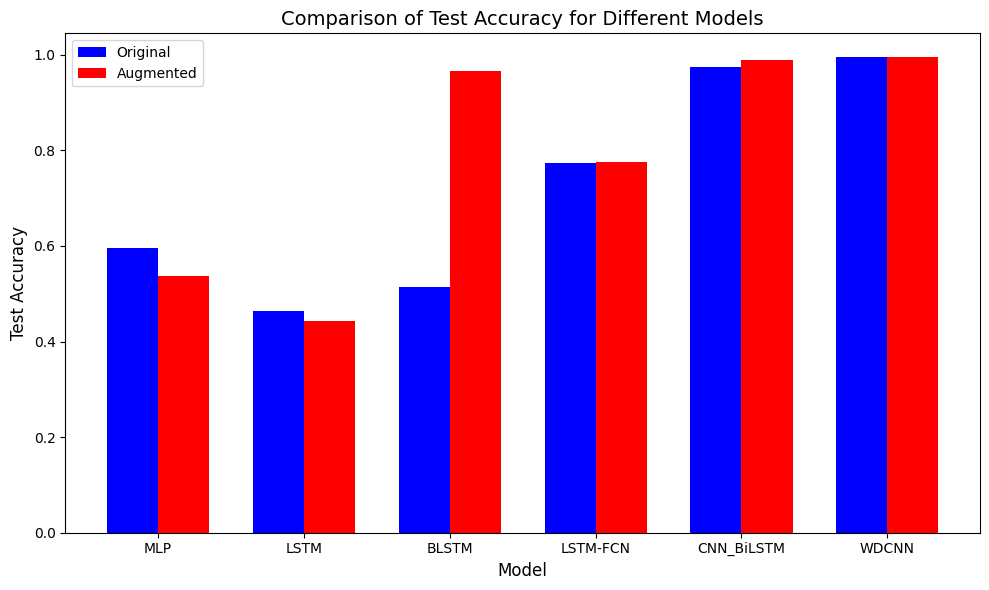

In [14]:
# Extract test accuracies for each model from both results
models = list(results_original.keys())
test_accuracies_original = [results_original[model]['test_accuracy'] for model in models]
test_accuracies_augmented = [results_augmented[model]['test_accuracy'] for model in models]

# Create the bar plot
bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, test_accuracies_original, bar_width, color='blue', label='Original')
bar2 = ax.bar([i + bar_width for i in index], test_accuracies_augmented, bar_width, color='red', label='Augmented')

# Labeling
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Comparison of Test Accuracy for Different Models', fontsize=14)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


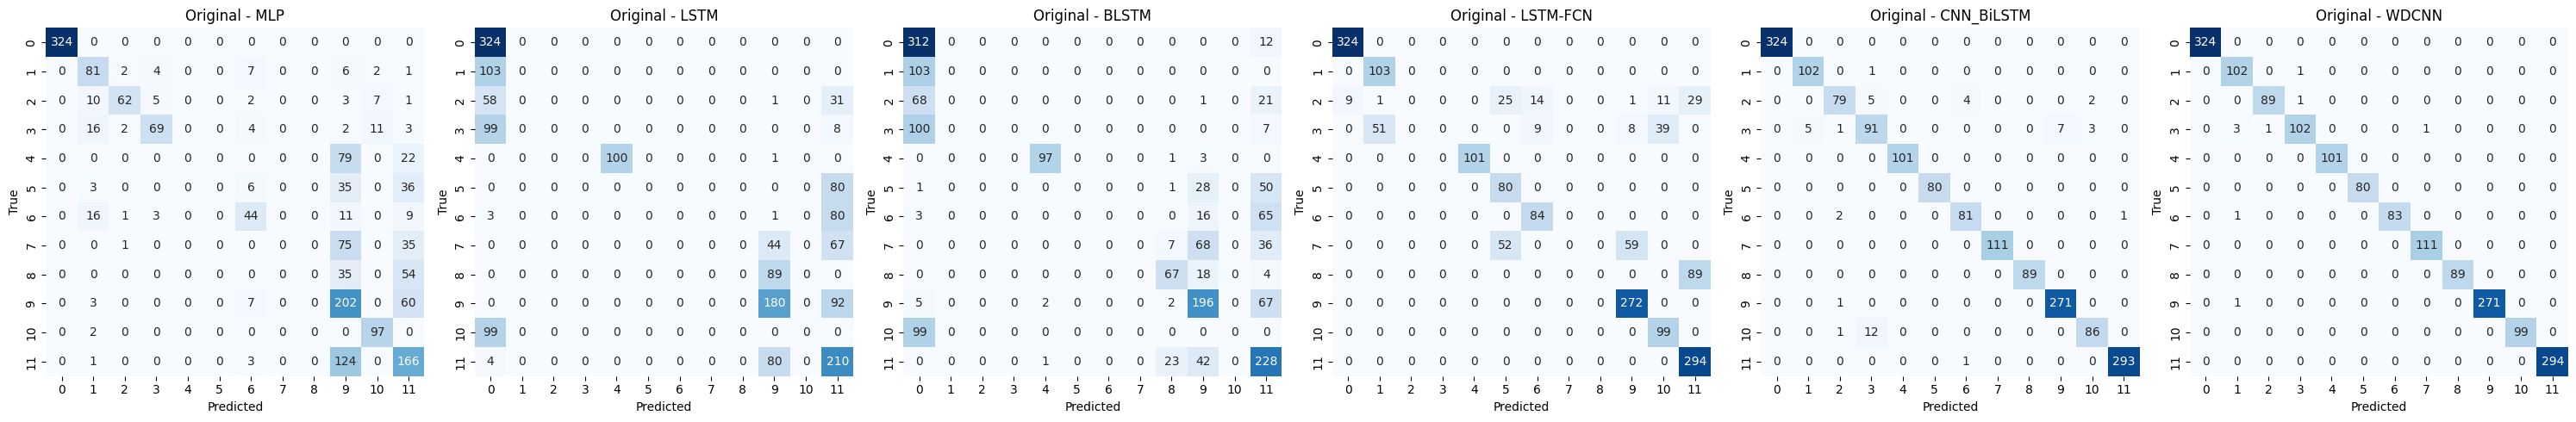

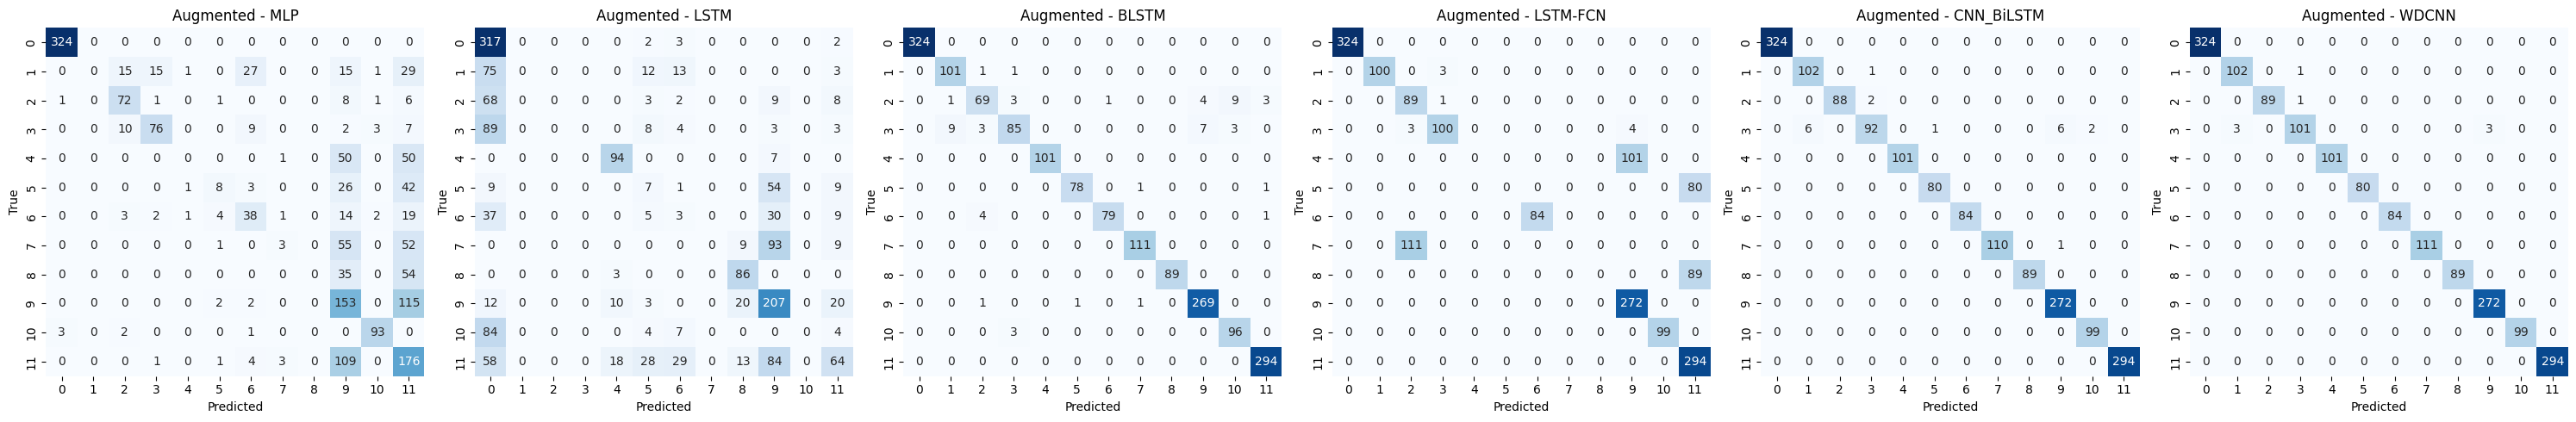

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrices(results_dict, y_test, title_prefix):
    """
    Plot confusion matrices for all models in a results dictionary.

    Parameters:
        results_dict (dict): Dictionary containing model results, with a 'preds' key for predictions.
        y_test (array-like): Ground truth labels.
        title_prefix (str): Prefix for the title of each plot.
    """
    num_models = len(results_dict)
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

    if num_models == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot.

    for ax, (model_name, model_results) in zip(axes, results_dict.items()):
        preds = model_results.get('preds', [])
        if len(preds) == 0:
            print(f"No predictions found for model {model_name}. Skipping...")
            continue
        cm = confusion_matrix(y_test, preds)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(f"{title_prefix} - {model_name}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
# Remplace `results_original` et `results_augmented` par tes dictionnaires et `y_test` par les labels réels.
plot_confusion_matrices(results_original, y_test, "Original")
plot_confusion_matrices(results_augmented, y_test, "Augmented")

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def generate_results_table(results_original, results_augmented, y_test, average="macro"):
    """
    Generate a summary table of accuracy, precision, recall, and F1-score for each model.

    Parameters:
        results_original (dict): Dictionary with original data results. Must include 'preds' for predictions.
        results_augmented (dict): Dictionary with augmented data results. Must include 'preds' for predictions.
        y_test (array-like): Ground truth labels.
        average (str): The averaging method for metrics ('micro', 'macro', 'weighted', etc.).

    Returns:
        pd.DataFrame: DataFrame summarizing metrics for each model.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
    rows = []

    for model_name in results_original:
        # Get predictions
        preds_original = results_original.get(model_name, {}).get("preds", [])
        preds_augmented = results_augmented.get(model_name, {}).get("preds", [])

        if len(preds_original) == 0 or len(preds_augmented) == 0:
            print(f"No predictions found for model {model_name}. Skipping...")
            continue

        # Calculate metrics for original data
        acc_orig = accuracy_score(y_test, preds_original) * 100
        prec_orig = precision_score(y_test, preds_original, average=average, zero_division=0) * 100
        recall_orig = recall_score(y_test, preds_original, average=average, zero_division=0) * 100
        f1_orig = f1_score(y_test, preds_original, average=average, zero_division=0) * 100

        # Calculate metrics for augmented data
        acc_aug = accuracy_score(y_test, preds_augmented) * 100
        prec_aug = precision_score(y_test, preds_augmented, average=average, zero_division=0) * 100
        recall_aug = recall_score(y_test, preds_augmented, average=average, zero_division=0) * 100
        f1_aug = f1_score(y_test, preds_augmented, average=average, zero_division=0) * 100

        # Add rows to the summary, formatting to 2 decimal places
        rows.append([model_name, "Original", f"{acc_orig:.2f}%", f"{prec_orig:.2f}%", f"{recall_orig:.2f}%", f"{f1_orig:.2f}%"])
        rows.append([model_name, "Augmented", f"{acc_aug:.2f}%", f"{prec_aug:.2f}%", f"{recall_aug:.2f}%", f"{f1_aug:.2f}%"])

    # Create DataFrame
    df = pd.DataFrame(rows, columns=["Model", "Data Type"] + metrics)
    return df

# Exemple d'utilisation
# Assurez-vous que `results_original` et `results_augmented` contiennent des prédictions sous la clé 'preds'.
summary_table = generate_results_table(results_original, results_augmented, y_test)

# Afficher le tableau
print(summary_table)

# Exporter le tableau en fichier CSV (optionnel)
summary_table.to_csv("model_comparison_results.csv", index=False)


         Model  Data Type Accuracy Precision  Recall F1-score
0          MLP   Original   59.58%    46.59%  49.43%   46.94%
1          MLP  Augmented   53.76%    44.74%  43.25%   41.08%
2         LSTM   Original   46.41%    19.12%  28.05%   22.17%
3         LSTM  Augmented   44.36%    24.22%  33.14%   26.63%
4        BLSTM   Original   51.31%    25.64%  34.77%   28.96%
5        BLSTM  Augmented   96.69%    95.90%  95.13%   95.41%
6     LSTM-FCN   Original   77.37%    50.92%  66.67%   57.16%
7     LSTM-FCN  Augmented   77.65%    56.30%  65.79%   59.63%
8   CNN_BiLSTM   Original   97.38%    96.56%  96.20%   96.35%
9   CNN_BiLSTM  Augmented   98.92%    98.80%  98.49%   98.61%
10       WDCNN   Original   99.49%    99.28%  99.31%   99.29%
11       WDCNN  Augmented   99.54%    99.51%  99.36%   99.43%
